<a href="https://colab.research.google.com/github/navneetkrc/Colab_fastai/blob/master/Colab_fastai/Recommender%20Systems/GoodBooks/Book_Recommendation_System_gilbert_tanner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Book Recommendation System

In [0]:
from fastai.collab import *

In [4]:
!ls

books.csv  ratings.csv	sample_data


In [7]:
ratings = pd.read_csv('ratings.csv')
ratings.head()

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [0]:
data = CollabDataBunch.from_df(ratings, seed=42, valid_pct=0.1, user_name='user_id', item_name='book_id', rating_name='rating')

In [9]:
data.show_batch()

user_id,book_id,target
3598,3788,5.0
34966,9155,3.0
25012,8231,4.0
42659,3004,3.0
26786,4308,4.0


In [10]:
ratings.rating.min(), ratings.rating.max()

(1, 5)

## EmbeddingDotBias Model

In [0]:
learn = collab_learner(data, n_factors=40, y_range=(1, 5), wd=1e-1, model_dir="/tmp/model/", path="/tmp/")

In [18]:
print(learn.summary())
# This gives us User Embeddings, Item EMbeddings, User Bias, and Item Bias

EmbeddingDotBias
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [40]                 2,134,040  True      
______________________________________________________________________
Embedding            [40]                 400,040    True      
______________________________________________________________________
Embedding            [1]                  53,351     True      
______________________________________________________________________
Embedding            [1]                  10,001     True      
______________________________________________________________________

Total params: 2,597,432
Total trainable params: 2,597,432
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function : FlattenedLoss
Callbacks functions applied 



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


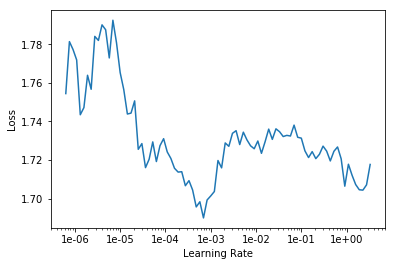

In [19]:
learn.lr_find()
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,time
0,1.632417,1.588838,01:25
1,1.318440,1.312134,01:25
2,1.122499,1.120099,01:26
3,1.029103,1.054762,01:28
4,1.000295,1.045265,01:26


In [0]:
learn.save('goodbooks-dot-1')

## EmbeddingNN Model

In [0]:
learn = collab_learner(data, use_nn=True, emb_szs={'user_id': 40, 'book_id':40}, layers=[256, 128], y_range=(1, 5))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


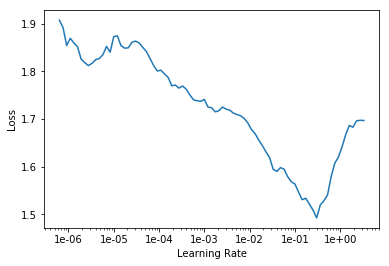

In [28]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, 1e-2)

In [0]:
learn.save('goodbooks-nn-1')

## Interpretation

In [0]:
learn = collab_learner(data, n_factors=40, y_range=(1, 5), wd=1e-1, model_dir="/tmp/model/", path="/tmp/")
learn.load('goodbooks-dot-1');

In [31]:
books = pd.read_csv('books.csv')
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,language_code,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",eng,4.34,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,eng,4.44,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,"Twilight (Twilight, #1)",en-US,3.57,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,To Kill a Mockingbird,eng,4.25,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,The Great Gatsby,eng,3.89,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [34]:
g = ratings.groupby('book_id')['rating'].count()
top_books = g.sort_values(ascending=False).index.values[:1000]
top_books = top_books.astype(str)
top_books[:10]

array(['5000', '3315', '3313', '3312', '3311', '3309', '3308', '3307', '3306', '3304'], dtype='<U21')

In [0]:
g = ratings.groupby('book_id')['rating'].count()
g

In [43]:
# create array containing the names of the top books
top_books_with_name = []
for book in top_books:
    top_books_with_name.append(books[(books['id']==int(book))]['title'].iloc[0])
top_books_with_name = np.array(top_books_with_name)
top_books_with_name

array(['Passion Unleashed (Demonica #3)', 'My Story', 'The Gargoyle', 'Pretty Baby', ...,
       'Top Secret Twenty-One (Stephanie Plum, #21)', 'The Warrior Heir (The Heir Chronicles, #1)', 'Stone Soup',
       'The Sixth Man (Sean King & Michelle Maxwell, #5)'], dtype='<U144')

## Book Bias

In [44]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(53351, 40)
  (i_weight): Embedding(10001, 40)
  (u_bias): Embedding(53351, 1)
  (i_bias): Embedding(10001, 1)
)

In [0]:
book_bias = learn.bias(top_books, is_item=True)

In [0]:
mean_ratings = ratings.groupby('book_id')['rating'].mean()
book_ratings = [(b, top_books_with_name[i], mean_ratings.loc[int(tb)]) for i, (tb, b) in enumerate(zip(top_books, book_bias))]

In [0]:
item0 = lambda o:o[0]

In [48]:
sorted(book_ratings, key=item0)[:15]

[(tensor(-0.0929), 'The Almost Moon', 2.49),
 (tensor(-0.0340), 'Skinny Bitch', 2.9),
 (tensor(-0.0326), 'The Particular Sadness of Lemon Cake', 2.93),
 (tensor(-0.0277), 'Bergdorf Blondes', 3.0),
 (tensor(-0.0217), 'The Weird Sisters', 3.08),
 (tensor(-0.0150), 'Nightfall (The Vampire Diaries: The Return, #1)', 3.12),
 (tensor(-0.0030), 'Swamplandia!', 3.02),
 (tensor(0.0004), 'Need (Need, #1)', 3.22),
 (tensor(0.0005), 'Vampire Kisses (Vampire Kisses, #1)', 3.18),
 (tensor(0.0040),
  'The Claiming of Sleeping Beauty (Sleeping Beauty, #1)',
  3.28),
 (tensor(0.0056), 'Last Night at Chateau Marmont', 3.07),
 (tensor(0.0067), 'Skipping Christmas', 3.25),
 (tensor(0.0077), 'Wreckage', 3.13),
 (tensor(0.0108), 'Lipstick Jungle', 3.12),
 (tensor(0.0157), 'The Face on the Milk Carton (Janie Johnson, #1)', 3.3)]

In [49]:
sorted(book_ratings, key=item0, reverse=True)[:15]

[(tensor(0.3179), 'The Kindly Ones (The Sandman #9)', 4.65),
 (tensor(0.3038), 'The Wake (The Sandman #10)', 4.65),
 (tensor(0.3032), 'The Story of a New Name (The Neapolitan Novels #2)', 4.23),
 (tensor(0.3011), 'Just Mercy: A Story of Justice and Redemption', 4.51),
 (tensor(0.3006),
  'Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5)',
  4.77),
 (tensor(0.3001),
  'Harry Potter and the Chamber of Secrets: Sheet Music for Flute with C.D',
  4.57),
 (tensor(0.2991),
  'The Story of the Lost Child (The Neapolitan Novels, #4)',
  4.38),
 (tensor(0.2963), 'Saga, Vol. 4 (Saga, #4)', 4.5),
 (tensor(0.2958), 'The Complete Calvin and Hobbes', 4.73),
 (tensor(0.2936), 'Crooked Kingdom (Six of Crows, #2)', 4.55),
 (tensor(0.2931), 'The Exploits of Sherlock Holmes', 4.46),
 (tensor(0.2925), 'A Game of You (The Sandman #5)', 4.56),
 (tensor(0.2908), 'The Arrival', 4.45),
 (tensor(0.2900), 'The Bands of Mourning (Mistborn, #6)', 4.37),
 (tensor(0.2870), 'Bone: The Complete Edition', 4.27)]

In [50]:
book_w = learn.weight(top_books, is_item=True)
book_w.shape

torch.Size([1000, 40])

In [51]:
book_pca = book_w.pca(3)
book_pca.shape

torch.Size([1000, 3])

In [0]:
fac0,fac1,fac2 = book_pca.t()
book_comp = [(f, i) for f,i in zip(fac0, top_books_with_name)]

In [53]:
sorted(book_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.5242), 'The Kindly Ones (The Sandman #9)'),
 (tensor(0.5040), 'The Wake (The Sandman #10)'),
 (tensor(0.4974), 'The Complete Calvin and Hobbes'),
 (tensor(0.4891), 'A Game of You (The Sandman #5)'),
 (tensor(0.4667), 'SantaLand Diaries'),
 (tensor(0.4644), 'Pale Fire'),
 (tensor(0.4644), 'The Complete Stories'),
 (tensor(0.4517), "The Razor's Edge"),
 (tensor(0.4493), 'Twenty Love Poems and a Song of Despair'),
 (tensor(0.4281),
  "The Hitchhiker's Guide to the Galaxy: A Trilogy in Four Parts")]

In [54]:
sorted(book_comp, key=itemgetter(0))[:10]

[(tensor(-0.6516), 'The Darkest Pleasure (Lords of the Underworld #3)'),
 (tensor(-0.6297), 'No Rest for the Wicked (Immortals After Dark #3)'),
 (tensor(-0.6162), 'Night Play (Dark-Hunter #5, Were-Hunter #1)'),
 (tensor(-0.6115),
  "Wicked Deeds on a Winter's Night (Immortals After Dark #4)"),
 (tensor(-0.5978), 'The Darkest Kiss (Lords of the Underworld #2)'),
 (tensor(-0.5974), 'A Hunger Like No Other (Immortals After Dark #2)'),
 (tensor(-0.5896), 'Passion Unleashed (Demonica #3)'),
 (tensor(-0.5743), 'Dance with the Devil (Dark-Hunter #3)'),
 (tensor(-0.5711), 'Night Embrace (Dark-Hunter #2)'),
 (tensor(-0.5637), 'The Warlord Wants Forever (Immortals After Dark #1)')]

In [0]:
book_comp = [(f, i) for f,i in zip(fac1, top_books_with_name)]

In [56]:
sorted(book_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(0.4845), 'Vampire Academy: The Ultimate Guide (Vampire Academy)'),
 (tensor(0.4703), 'Hunting Ground (Alpha & Omega, #2)'),
 (tensor(0.4481), 'Crooked Kingdom (Six of Crows, #2)'),
 (tensor(0.4456), 'Beauty and the Beast (Disney)'),
 (tensor(0.4399), 'Harry Potter Boxed Set, Books 1-5 (Harry Potter, #1-5)'),
 (tensor(0.4395), "The Assassin's Blade (Throne of Glass, #0.1-0.5)"),
 (tensor(0.4323), 'Frost Burned (Mercy Thompson, #7)'),
 (tensor(0.4309),
  'Harry Potter and the Chamber of Secrets: Sheet Music for Flute with C.D'),
 (tensor(0.4246), 'River Marked (Mercy Thompson, #6)'),
 (tensor(0.4226), 'Fueled (Driven, #2)')]

In [57]:
sorted(book_comp, key=itemgetter(0))[:10]

[(tensor(-0.5193), 'The Almost Moon'),
 (tensor(-0.5117), 'Swamplandia!'),
 (tensor(-0.4953), 'Wreckage'),
 (tensor(-0.4885), 'The Weird Sisters'),
 (tensor(-0.4761), 'Skinny Bitch'),
 (tensor(-0.4739), 'Sweet Tooth'),
 (tensor(-0.4610), 'The Particular Sadness of Lemon Cake'),
 (tensor(-0.4492), 'Shopgirl'),
 (tensor(-0.4368), 'The Woman Upstairs'),
 (tensor(-0.4358), 'Housekeeping')]

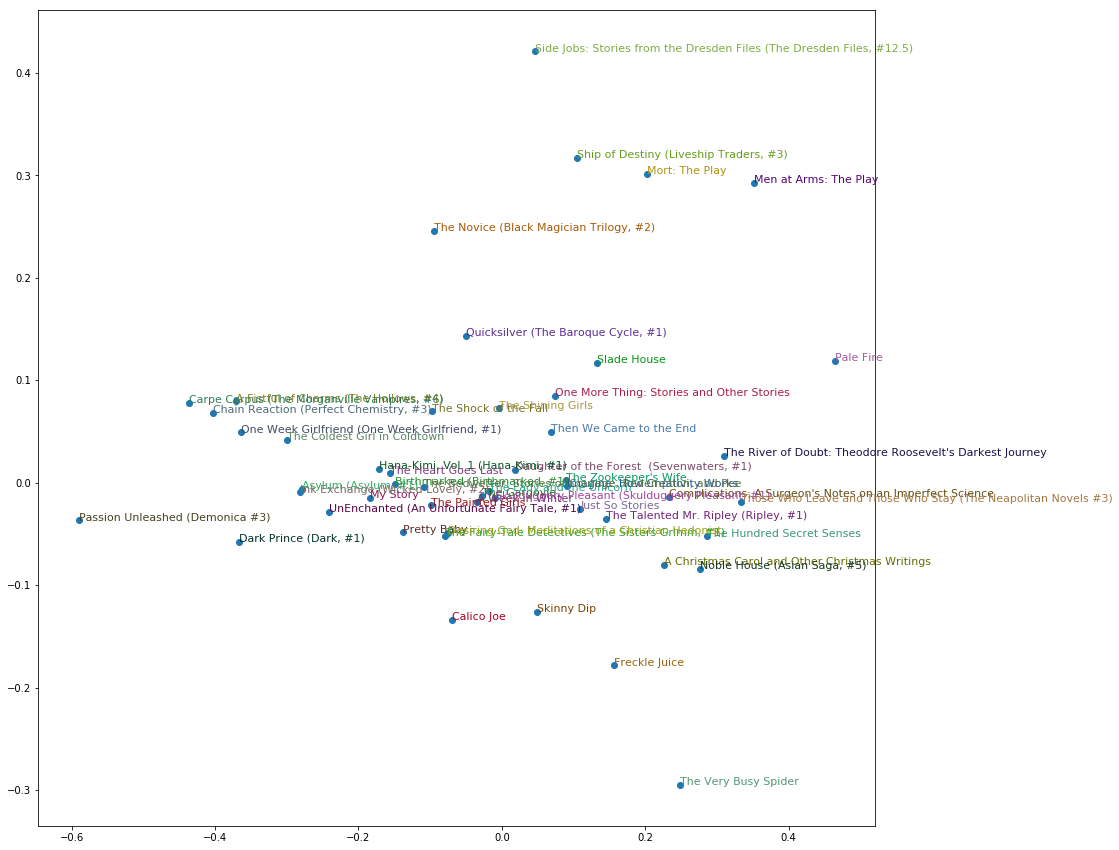

In [58]:
idxs = np.random.choice(len(top_books_with_name), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_books_with_name[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()